# Quantum Simulation of a Biosafety Logic Circuit for a Pollutant-Eating Biospray 🧬

This notebook presents a quantum logic simulation that models the biosafety decision system from the [Pollutant-Eating Biospray Project](https://awake-pot-132.notion.site/SynBio-Project-Engineering-a-PAH-Detecting-and-Degrading-Biospray-Using-Pseudomonas-putida-275d15e7a8e480c58c18f95504988d2e?source=copy_link&authuser=0).

In the biospray design, engineered bacteria are programmed to detect and degrade toxic air pollutants while ensuring environmental safety through a built-in kill-switch.
This logic can be expressed as:

K = M OR T OR G

where

• M → Mutation detected

• T → Timer expiry (pollutant absent too long)

• G → Geosensing alert (outside the designated area)

In this notebook, that same rule is implemented using quantum logic gates in Qiskit, showing how biological decision-making can be represented through reversible quantum operations.

The simulation includes:

✅ Classical vs Quantum truth table comparison

✅ Quantum superposition and noise simulations

✅ Visualization of probabilistic kill outcomes

This is a conceptual demonstration, not a biological experiment, it bridges synthetic biology and quantum computing through logical modeling.

## 1. Background and Motivation

Biological systems such as the engineered biospray rely on *multi-input logic* — combining environmental, genetic, and temporal signals to decide whether a cell should replicate, degrade pollutants, or self-terminate.  
This is analogous to quantum logic, where multiple qubits influence a single probabilistic outcome.

Here, we simulate the biospray’s **kill-switch logic** using a quantum circuit framework.  
Inputs represent biological signals:
- **Mutation (M):** DNA damage or genetic instability  
- **Geosensing (G):** Bacteria outside designated geography  
- **Timer (T):** The absence of pollutants for a defined time (~1 hr)

The system’s output, **Kill (K)**, is determined by:
\[
K = M + T + G
\]
This equation mimics the biosafety rule used in the *pSafe* plasmid of the biospray system.

Quantum circuits provide a way to explore this rule not as a binary ON/OFF response, but as a **probabilistic state** — reflecting biological uncertainty, noise, and interaction among multiple inputs.


⚙️ 1. Imports and Setup

We begin by importing the required libraries and setting up the environment.
The simulation is built using Qiskit with support from AerSimulator for ideal and noisy runs.
Helper libraries such as matplotlib, pandas, and itertools handle plotting and truth table generation.

In [ ]:
pip install qiskit qiskit-aer matplotlib pylatexenc

In [12]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# --------------------------- Setup ---------------------------
plt.rcParams["figure.dpi"] = 120

🧩 2. Define the Biosafety Logic

In the biospray design, the “kill-switch” ensures that bacterial survival is tightly regulated.
The classical rule is defined as:

K=T+M+G

where:

M = Mutation detected

T = Timer expired (no pollutants detected for a while)

G = Geosensing out of safe region

K = Kill signal

The bacteria self-terminate whenever any of these inputs is true.
We define this rule both in classical logic and as a quantum circuit built with reversible gates.

In [13]:
# ---------- Classical kill rule ----------
def kill_rule_classical(mutation, timer, geosense):
    """
    Classical kill rule for biospray safety logic.
    K = T OR M OR G
    """
    return int(mutation or timer or geosense)

🧮 Step 3 — Building the Quantum Logic Circuit

Text cell:
We now construct a reversible quantum circuit that mirrors the same biological logic.
Each qubit represents one input condition, and Toffoli (CCX) gates are used to implement the multi-input OR operation.
Quantum reversibility ensures that the system conserves information, similar to how biological regulation can reverse or override signals under controlled feedback.

In [14]:
# ---------- Build reversible quantum circuit ----------
def build_reversible_kill_circuit():
    """
    Build a reversible quantum circuit implementing:
        K = T OR M OR G
    using basic quantum logic gates.
    Qubit mapping:
        q0 = M (Mutation)
        q1 = T (Timer)
        q2 = G (Geosensing)
        q3 = Ancilla
        q4 = K (Kill output)
    """
    qr = QuantumRegister(5, "q")
    cr = ClassicalRegister(1, "c")  # measure kill output
    qc = QuantumCircuit(qr, cr)

    # Step 1: Initialize kill bit to 0
    qc.reset(qr[4])

    # Step 2: XOR inputs into output (sets kill=1 when odd number of inputs 1)
    qc.cx(qr[0], qr[4])
    qc.cx(qr[1], qr[4])
    qc.cx(qr[2], qr[4])

    # Step 3: Toffoli gates correct parity to form proper OR (1 if any input = 1)
    qc.ccx(qr[0], qr[1], qr[4])
    qc.ccx(qr[0], qr[2], qr[4])
    qc.ccx(qr[1], qr[2], qr[4])

    return qc, qr, cr

🔢 3. Classical vs Quantum Truth Table

Here we test the circuit by iterating through all possible input combinations of M, T, and G.
For each state, we record:

The classical output from the Boolean rule

The quantum-measured probability of a kill signal

The results demonstrate that the quantum model reproduces the expected logic while allowing for probabilistic representation.

In [15]:
# ---------- Quantum truth table ----------
def evaluate_truth_table_quantum():
    backend = AerSimulator()
    qc_base, qr, cr = build_reversible_kill_circuit()
    rows = []

    for mutation, timer, geosense in product([0, 1], repeat=3):
        qc = qc_base.copy()
        prep = QuantumCircuit(qr, cr)
        if mutation:
            prep.x(qr[0])
        if timer:
            prep.x(qr[1])
        if geosense:
            prep.x(qr[2])

        full = prep.compose(qc)
        full.measure(qr[4], cr[0])

        compiled = transpile(full, backend)
        res = backend.run(compiled, shots=1024).result()
        counts = res.get_counts()

        total_shots = sum(counts.values())
        prob_kill = sum(
            cnt for bitstring, cnt in counts.items() if bitstring[0] == "1"
        ) / total_shots

        rows.append(
            {
                "Mutation": mutation,
                "Timer": timer,
                "Geosensing": geosense,
                "Quantum_Prob_Kill": prob_kill,
                "Classical_Kill": kill_rule_classical(mutation, timer, geosense),
            }
        )

    df = pd.DataFrame(rows)
    return df

🔮 4. Quantum Superposition Simulation

To explore how the biosafety logic behaves in quantum form, we place all three inputs in superposition using Hadamard gates.
This allows the circuit to evaluate all possible states simultaneously.

We then visualize the measured outcomes as a histogram showing the probability distribution of output states.

In [16]:
# ---------- Quantum Superposition Simulation ----------
def superposition_counts(noisy=False, noise_model=None):
    qc_base, qr, _ = build_reversible_kill_circuit()
    cr = ClassicalRegister(5, "c")  # ✅ FIX: create 5 classical bits
    prep = QuantumCircuit(qr, cr)
    prep.h([qr[0], qr[1], qr[2]])  # put all inputs in superposition
    full = prep.compose(qc_base)
    full.measure([qr[4], qr[3], qr[2], qr[1], qr[0]], range(5))  # ✅ now valid

    backend = AerSimulator()
    compiled = transpile(full, backend)
    job = backend.run(compiled, shots=4096, noise_model=noise_model if noisy else None)
    return job.result().get_counts()

⚡ 5. Noisy Quantum Simulation

To mimic real-world imperfections, we introduce a simple noise model that includes:

*   Depolarizing errors (affecting 1-, 2-, and 3-qubit gates)
*   Readout errors during measurement

This reflects biological uncertainty just as bacteria experience imperfect sensing or fluctuating environments.
We then re-run the simulation with noise and compare the distributions.

In [17]:
# ---------- Noise Model ----------
def build_simple_noise_model(p1=0.002, p2=0.02, readout_err=0.03):
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(
        depolarizing_error(p1, 1), ["u1", "u2", "u3", "x", "h"]
    )
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ["cx"])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p2 * 1.5, 3), ["ccx"])
    readout = ReadoutError(
        [[1 - readout_err, readout_err], [readout_err, 1 - readout_err]]
    )
    noise_model.add_all_qubit_readout_error(readout)
    return noise_model

1️⃣ Classical vs Quantum truth table (ideal simulator):
 Mutation  Timer  Geosensing  Quantum_Prob_Kill  Classical_Kill
        0      0           0                0.0               0
        0      0           1                1.0               1
        0      1           0                1.0               1
        0      1           1                1.0               1
        1      0           0                1.0               1
        1      0           1                1.0               1
        1      1           0                1.0               1
        1      1           1                0.0               1

2️⃣ Quantum superposition counts (ideal):
Sample: [('01101', 515), ('01001', 528), ('10101', 542), ('11100', 496), ('00101', 467)]


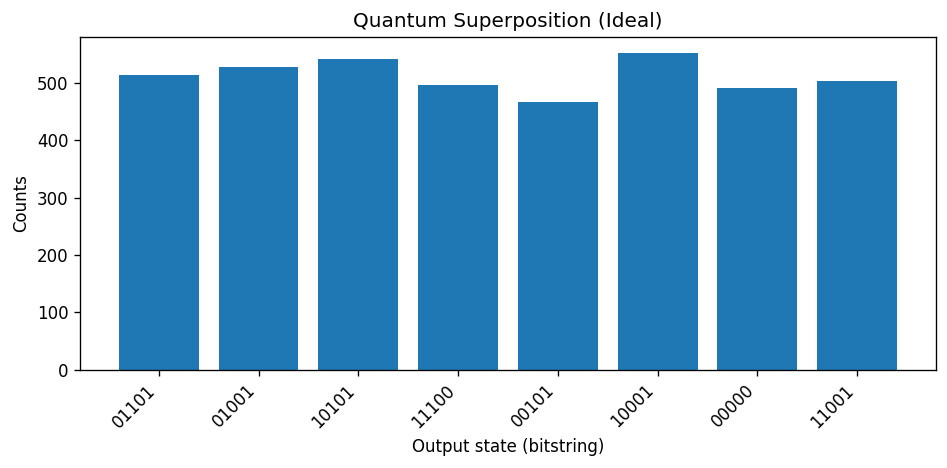


3️⃣ Quantum superposition counts (noisy):
Sample: [('00011', 2), ('10110', 3), ('00110', 2), ('00001', 73), ('11100', 409)]


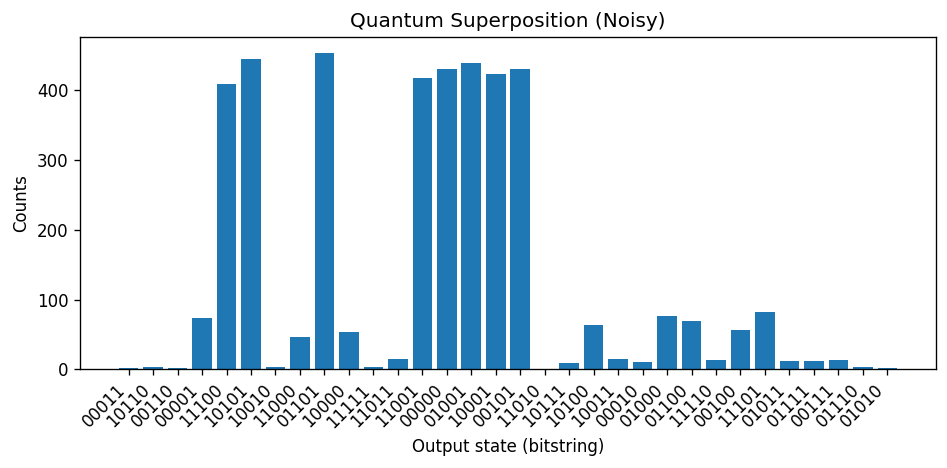


✅ All simulations completed successfully.


In [18]:
# ---------- Helper: Plotting Function ----------
def plot_counts(counts_dict, title, save=False):
    if not counts_dict:
        print("No data to plot for", title)
        return
    labels = list(counts_dict.keys())
    values = list(counts_dict.values())

    plt.figure(figsize=(8, 4))
    plt.bar(range(len(labels)), values, tick_label=labels)
    plt.xticks(rotation=45, ha="right")
    plt.title(title)
    plt.xlabel("Output state (bitstring)")
    plt.ylabel("Counts")
    plt.tight_layout()
    plt.show()

    if save:
        os.makedirs("plots", exist_ok=True)
        plt.savefig(f"plots/{title.replace(' ', '_')}.png", dpi=300, bbox_inches="tight")
        print(f"Saved: plots/{title.replace(' ', '_')}.png")


# --------------------------- MAIN ---------------------------
if __name__ == "__main__":
    print("1️⃣ Classical vs Quantum truth table (ideal simulator):")
    df = evaluate_truth_table_quantum()
    print(df.to_string(index=False))

    print("\n2️⃣ Quantum superposition counts (ideal):")
    counts = superposition_counts(noisy=False)
    print("Sample:", list(counts.items())[:5])
    plot_counts(counts, "Quantum Superposition (Ideal)")

    print("\n3️⃣ Quantum superposition counts (noisy):")
    noise = build_simple_noise_model()
    noisy_counts = superposition_counts(noisy=True, noise_model=noise)
    print("Sample:", list(noisy_counts.items())[:5])
    plot_counts(noisy_counts, "Quantum Superposition (Noisy)")

    print("\n✅ All simulations completed successfully.")


🧠 Observations

- Both the ideal and noisy simulations show that the quantum system correctly reproduces the biosafety rule (K = M OR T OR G).

- In noisy conditions, the probability spread becomes more irregular, analogous to biological “error” or uncertainty in sensing and control.

- The model remains conceptual but provides a compact example of how biosafety logic could be visualized through quantum computation principles.

# Summary

Text cell:
This notebook demonstrates how synthetic biology logic can be expressed using quantum circuits.
Although simple, it represents an important educational crossover between biological computation and quantum information science.

The circuit uses:

- X (NOT) and CX (CNOT) gates for conditional toggling

- CCX (Toffoli) gates for multi-input control

- Hadamard (H) gates to create superposition

- NoiseModel to simulate real-world decoherence

🧬 Project Link

To learn more about the underlying biospray concept that inspired this simulation:
👉 [Pollutant-Eating Biospray Project](https://awake-pot-132.notion.site/SynBio-Project-Engineering-a-PAH-Detecting-and-Degrading-Biospray-Using-Pseudomonas-putida-275d15e7a8e480c58c18f95504988d2e?source=copy_link&authuser=0)